# Libraries and dataset

In [2]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import train_test_split
import tensorflow as tf
gpu = len(tf.config.list_physical_devices('GPU'))>0
from tensorflow import keras
from keras.models import Sequential 
from keras.layers import Dense, Activation, Input
import keras.backend as K 
print(gpu)

True


In [2]:
df_1991 = pd.read_csv("./dataset/1991.csv",  encoding='latin-1')
df_2001 = pd.read_csv("./dataset/2001.csv",  encoding='latin-1')

In [3]:
df_airport = pd.read_csv("./dataset/airports.csv")
df_carriers = pd.read_csv("./dataset/carriers.csv")

# Flight Data

https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/HG7NV7

Variable descriptions: 

1 Year 1987-2008 **useuful**

2 Month 1-12 **useuful**

3 DayofMonth 1-31 **useuful**

4 DayOfWeek 1 (Monday) - 7 (Sunday) **useuful**

5 DepTime actual departure time (local, hhmm) **useuful**

6 CRSDepTime scheduled departure time (local, hhmm) **useuful**

7 ArrTime actual arrival time (local, hhmm) **useuful**

8 CRSArrTime scheduled arrival time (local, hhmm) **useuful**

9 UniqueCarrier unique carrier code **useuful**

10 FlightNum flight number **useuful**

11 TailNum plane tail number **not useful (1991 has 100% null)**

12 ActualElapsedTime in minutes **not useuful (ArrTime - DepTime)**

13 CRSElapsedTime in minutes **useuful, it's the expected flight duration**

14 AirTime in minutes **not useuful**

15 ArrDelay arrival delay, in minutes **useuful (on time flight has ArrDelay = 0, It's our target variable for classification)**

16 DepDelay departure delay, in minutes **useuful (might be associated to ArrDelay)**

17 Origin origin IATA airport code **useuful**

18 Dest des tination IATA airport code **useuful**

19 Distance in miles **not useuful**

20 TaxiIn taxi in time, in minutes **not useuful**

21 TaxiOut taxi out time in minutes **not useuful**

22 Cancelled was the flight cancelled? **not useuful (we are not interested in cancelled flights. To remove rows if = 1)**

23 CancellationCode reason for cancellation (A = carrier, B = weather, C = NAS, D = security) **not useuful (all null)**

24 Diverted 1 = yes, 0 = no **not useuful (we are not interested in cancelled flights. To remove rows if = 1)**

25 CarrierDelay in minutes **not useuful (all null)**

26 WeatherDelay in minutes **not useuful (all null)**

27 NASDelay in minutes **not useuful (all null)**

28 SecurityDelay in minutes **not useuful (all null)**

29 LateAircraftDelay in minutes **not useuful (all null)**

Compare 1991 and 2001 with respect to:
- What characterises flights that are on time? (descriptive) --> **On time means that the arrivalDelay = 0**
    - Exploratory analysis + clustering
- Add your own analytics (predictive, prescriptive) question and answer it.
    - Predictive: How can we predict if a flight will arrive on time? Classification problem
    - Prescriptive: What should we improve in order to increase the % of on time arrivals?

DepDelay indicates the delay of the flight related to the scheduled departure time (CRSDepTime) at the airport 'X-1'

ArrDelay indicates the delay of the flight related to the scheduled arrival time (CRSArrTime) at the airport 'X'

So the flights are from airport 'X-1' to 'X'

In [144]:
df_1991[["DepTime", "CRSDepTime", "ArrTime", "CRSArrTime", "ArrDelay", "DepDelay", "CRSElapsedTime"]]

,DepTime,CRSDepTime,ArrTime,CRSArrTime,ArrDelay,DepDelay,CRSElapsedTime
0,1709.0,1705,1944.0,1944,0.0,4.0,159
1,1704.0,1705,1946.0,1944,2.0,-1.0,159
2,1705.0,1705,1934.0,1944,-10.0,0.0,159
3,1709.0,1705,1951.0,1944,7.0,4.0,159
4,1703.0,1705,1936.0,1944,-8.0,-2.0,159
...,...,...,...,...,...,...,...
5076920,1130.0,1130,1413.0,1359,14.0,0.0,149
5076921,1130.0,1130,1353.0,1359,-6.0,0.0,149
5076922,1128.0,1130,1356.0,1359,-3.0,-2.0,149
5076923,1130.0,1130,1402.0,1359,3.0,0.0,149


example over the first flight:

- CRSDepTime = 17:05
- DepTime = 17:09
- We have 4 minutes of departure delay = DepDelay

- CRSArrTime = 19:44
- ArrTime = 19:44
- We have 0 minutes of arrival delay = ArrDelay

So first the is the departure, then the arrival. This means that the departure is from airport X-1 and the arrival at airport X

The CRSElapsedTime is the flight duration as it was scheduled. Example:

19.44 - 17.05 = 159'

**CRSElapsedTime = CRSArrTime - CRSDepTime**

The ActualElapsedTime is the actual flight duration.

**ActualElapsedTime = ArrTime - DepTime**

## Pre-processing

In [4]:
df_1991

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,...,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,1991,1,1,2,1709.0,1705,1944.0,1944,US,112,...,NaN,NaN,0,NaN,0,NaN,NaN,NaN,NaN,NaN
1,1991,1,2,3,1704.0,1705,1946.0,1944,US,112,...,NaN,NaN,0,NaN,0,NaN,NaN,NaN,NaN,NaN
2,1991,1,3,4,1705.0,1705,1934.0,1944,US,112,...,NaN,NaN,0,NaN,0,NaN,NaN,NaN,NaN,NaN
3,1991,1,4,5,1709.0,1705,1951.0,1944,US,112,...,NaN,NaN,0,NaN,0,NaN,NaN,NaN,NaN,NaN
4,1991,1,5,6,1703.0,1705,1936.0,1944,US,112,...,NaN,NaN,0,NaN,0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5076920,1991,12,8,7,1130.0,1130,1413.0,1359,CO,1550,...,NaN,NaN,0,NaN,0,NaN,NaN,NaN,NaN,NaN
5076921,1991,12,9,1,1130.0,1130,1353.0,1359,CO,1550,...,NaN,NaN,0,NaN,0,NaN,NaN,NaN,NaN,NaN
5076922,1991,12,10,2,1128.0,1130,1356.0,1359,CO,1550,...,NaN,NaN,0,NaN,0,NaN,NaN,NaN,NaN,NaN
5076923,1991,12,11,3,1130.0,1130,1402.0,1359,CO,1550,...,NaN,NaN,0,NaN,0,NaN,NaN,NaN,NaN,NaN


In [5]:
df_2001

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,...,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,2001,1,17,3,1806.0,1810,1931.0,1934,US,375,...,5,20,0,NaN,0,NaN,NaN,NaN,NaN,NaN
1,2001,1,18,4,1805.0,1810,1938.0,1934,US,375,...,9,20,0,NaN,0,NaN,NaN,NaN,NaN,NaN
2,2001,1,19,5,1821.0,1810,1957.0,1934,US,375,...,6,10,0,NaN,0,NaN,NaN,NaN,NaN,NaN
3,2001,1,20,6,1807.0,1810,1944.0,1934,US,375,...,4,27,0,NaN,0,NaN,NaN,NaN,NaN,NaN
4,2001,1,21,7,1810.0,1810,1954.0,1934,US,375,...,4,38,0,NaN,0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5967775,2001,12,14,5,704.0,700,1159.0,1155,DL,678,...,14,13,0,NaN,0,NaN,NaN,NaN,NaN,NaN
5967776,2001,12,15,6,708.0,700,1158.0,1155,DL,678,...,9,18,0,NaN,0,NaN,NaN,NaN,NaN,NaN
5967777,2001,12,16,7,656.0,700,1147.0,1155,DL,678,...,7,11,0,NaN,0,NaN,NaN,NaN,NaN,NaN
5967778,2001,12,17,1,656.0,700,1151.0,1155,DL,678,...,13,11,0,NaN,0,NaN,NaN,NaN,NaN,NaN


In [6]:
df_1991.columns

Index(['Year', 'Month', 'DayofMonth', 'DayOfWeek', 'DepTime', 'CRSDepTime',
       'ArrTime', 'CRSArrTime', 'UniqueCarrier', 'FlightNum', 'TailNum',
       'ActualElapsedTime', 'CRSElapsedTime', 'AirTime', 'ArrDelay',
       'DepDelay', 'Origin', 'Dest', 'Distance', 'TaxiIn', 'TaxiOut',
       'Cancelled', 'CancellationCode', 'Diverted', 'CarrierDelay',
       'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay'],
      dtype='object')

In [7]:
df_2001.columns

Index(['Year', 'Month', 'DayofMonth', 'DayOfWeek', 'DepTime', 'CRSDepTime',
       'ArrTime', 'CRSArrTime', 'UniqueCarrier', 'FlightNum', 'TailNum',
       'ActualElapsedTime', 'CRSElapsedTime', 'AirTime', 'ArrDelay',
       'DepDelay', 'Origin', 'Dest', 'Distance', 'TaxiIn', 'TaxiOut',
       'Cancelled', 'CancellationCode', 'Diverted', 'CarrierDelay',
       'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay'],
      dtype='object')

In [8]:
df_2001.columns.values == df_1991.columns.values

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True])

In [9]:
df_1991.isna().sum()/df_1991.shape[0]*100

Year                   0.000000
Month                  0.000000
DayofMonth             0.000000
DayOfWeek              0.000000
DepTime                0.856916
CRSDepTime             0.000000
ArrTime                1.104803
CRSArrTime             0.000000
UniqueCarrier          0.000000
FlightNum              0.000000
TailNum              100.000000
ActualElapsedTime      1.104803
CRSElapsedTime         0.000000
AirTime              100.000000
ArrDelay               1.104803
DepDelay               0.856916
Origin                 0.000000
Dest                   0.000000
Distance               0.517262
TaxiIn               100.000000
TaxiOut              100.000000
Cancelled              0.000000
CancellationCode     100.000000
Diverted               0.000000
CarrierDelay         100.000000
WeatherDelay         100.000000
NASDelay             100.000000
SecurityDelay        100.000000
LateAircraftDelay    100.000000
dtype: float64

In [10]:
df_2001.isna().sum()/df_2001.shape[0]*100

Year                   0.000000
Month                  0.000000
DayofMonth             0.000000
DayOfWeek              0.000000
DepTime                3.874104
CRSDepTime             0.000000
ArrTime                4.090416
CRSArrTime             0.000000
UniqueCarrier          0.000000
FlightNum              0.000000
TailNum                0.000000
ActualElapsedTime      4.090416
CRSElapsedTime         0.000000
AirTime                4.090416
ArrDelay               4.090416
DepDelay               3.874104
Origin                 0.000000
Dest                   0.000000
Distance               0.000000
TaxiIn                 0.000000
TaxiOut                0.000000
Cancelled              0.000000
CancellationCode     100.000000
Diverted               0.000000
CarrierDelay         100.000000
WeatherDelay         100.000000
NASDelay             100.000000
SecurityDelay        100.000000
LateAircraftDelay    100.000000
dtype: float64

In [11]:
df_1991[df_1991["Cancelled"] == 1].shape[0]/df_1991.shape[0] * 100

0.8569163420771431

In [12]:
df_2001[df_2001["Cancelled"] == 1].shape[0]/df_2001.shape[0] * 100

3.874103938147854

In [13]:
df_2001[df_2001["Diverted"] == 1].shape[0]/df_2001.shape[0] * 100

0.21631159325578353

In [14]:
df_1991[df_1991["Diverted"] == 1].shape[0]/df_1991.shape[0] * 100

0.24788626974004935

Remove cancelled and diverted flights

In [15]:
df_1991.drop(df_1991[df_1991['Cancelled'] == 1].index, inplace = True)
df_2001.drop(df_2001[df_2001['Cancelled'] == 1].index, inplace = True)

In [16]:
df_1991.drop(df_1991[df_1991['Diverted'] == 1].index, inplace = True)
df_2001.drop(df_2001[df_2001['Diverted'] == 1].index, inplace = True)

In [17]:
df_1991.reset_index(drop=True, inplace=True)
df_2001.reset_index(drop=True, inplace=True)

In [18]:
drop_columns=[  'ActualElapsedTime', 'AirTime', 'Distance', 'TaxiIn', 'TaxiOut','CancellationCode','Diverted', 'Cancelled', 'Diverted',
                'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay', 'TailNum', "CRSElapsedTime"]

In [19]:
df_1991.drop(drop_columns, axis=1, inplace = True)
df_2001.drop(drop_columns, axis=1, inplace = True)

In [20]:
df_1991.columns

Index(['Year', 'Month', 'DayofMonth', 'DayOfWeek', 'DepTime', 'CRSDepTime',
       'ArrTime', 'CRSArrTime', 'UniqueCarrier', 'FlightNum', 'ArrDelay',
       'DepDelay', 'Origin', 'Dest'],
      dtype='object')

In [21]:
df_2001.columns

Index(['Year', 'Month', 'DayofMonth', 'DayOfWeek', 'DepTime', 'CRSDepTime',
       'ArrTime', 'CRSArrTime', 'UniqueCarrier', 'FlightNum', 'ArrDelay',
       'DepDelay', 'Origin', 'Dest'],
      dtype='object')

Variable descriptions: 

1 Year 1987-2008

2 Month 1-12

3 DayofMonth 1-31

4 DayOfWeek 1 (Monday) - 7 (Sunday)

5 DepTime actual departure time (local, hhmm)

6 CRSDepTime scheduled departure time (local, hhmm)

7 ArrTime actual arrival time (local, hhmm)

8 CRSArrTime scheduled arrival time (local, hhmm)

9 UniqueCarrier unique carrier code

10 FlightNum flight number

11 ArrDelay arrival delay, in minutes

12 DepDelay departure delay, in minutes

13 Origin origin IATA airport code

14 Dest destination IATA airport code


In [23]:
df_2001

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,ArrDelay,DepDelay,Origin,Dest
0,2001,1,17,3,1806.0,1810,1931.0,1934,US,375,-3.0,-4.0,BWI,CLT
1,2001,1,18,4,1805.0,1810,1938.0,1934,US,375,4.0,-5.0,BWI,CLT
2,2001,1,19,5,1821.0,1810,1957.0,1934,US,375,23.0,11.0,BWI,CLT
3,2001,1,20,6,1807.0,1810,1944.0,1934,US,375,10.0,-3.0,BWI,CLT
4,2001,1,21,7,1810.0,1810,1954.0,1934,US,375,20.0,0.0,BWI,CLT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5723668,2001,12,14,5,704.0,700,1159.0,1155,DL,678,4.0,4.0,ONT,DFW
5723669,2001,12,15,6,708.0,700,1158.0,1155,DL,678,3.0,8.0,ONT,DFW
5723670,2001,12,16,7,656.0,700,1147.0,1155,DL,678,-8.0,-4.0,ONT,DFW
5723671,2001,12,17,1,656.0,700,1151.0,1155,DL,678,-4.0,-4.0,ONT,DFW


In [24]:
df_1991

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,ArrDelay,DepDelay,Origin,Dest
0,1991,1,1,2,1709.0,1705,1944.0,1944,US,112,0.0,4.0,TPA,SYR
1,1991,1,2,3,1704.0,1705,1946.0,1944,US,112,2.0,-1.0,TPA,SYR
2,1991,1,3,4,1705.0,1705,1934.0,1944,US,112,-10.0,0.0,TPA,SYR
3,1991,1,4,5,1709.0,1705,1951.0,1944,US,112,7.0,4.0,TPA,SYR
4,1991,1,5,6,1703.0,1705,1936.0,1944,US,112,-8.0,-2.0,TPA,SYR
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5020830,1991,12,8,7,1130.0,1130,1413.0,1359,CO,1550,14.0,0.0,MCO,LGA
5020831,1991,12,9,1,1130.0,1130,1353.0,1359,CO,1550,-6.0,0.0,MCO,LGA
5020832,1991,12,10,2,1128.0,1130,1356.0,1359,CO,1550,-3.0,-2.0,MCO,LGA
5020833,1991,12,11,3,1130.0,1130,1402.0,1359,CO,1550,3.0,0.0,MCO,LGA


In [25]:
df_1991['DepTime'] = df_1991['DepTime'].astype(int)
df_1991['CRSDepTime'] = df_1991['CRSDepTime'].astype(int)
df_1991['ArrTime'] = df_1991['ArrTime'].astype(int)
df_1991['CRSArrTime'] = df_1991['CRSArrTime'].astype(int)
df_1991

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,ArrDelay,DepDelay,Origin,Dest
0,1991,1,1,2,1709,1705,1944,1944,US,112,0.0,4.0,TPA,SYR
1,1991,1,2,3,1704,1705,1946,1944,US,112,2.0,-1.0,TPA,SYR
2,1991,1,3,4,1705,1705,1934,1944,US,112,-10.0,0.0,TPA,SYR
3,1991,1,4,5,1709,1705,1951,1944,US,112,7.0,4.0,TPA,SYR
4,1991,1,5,6,1703,1705,1936,1944,US,112,-8.0,-2.0,TPA,SYR
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5020830,1991,12,8,7,1130,1130,1413,1359,CO,1550,14.0,0.0,MCO,LGA
5020831,1991,12,9,1,1130,1130,1353,1359,CO,1550,-6.0,0.0,MCO,LGA
5020832,1991,12,10,2,1128,1130,1356,1359,CO,1550,-3.0,-2.0,MCO,LGA
5020833,1991,12,11,3,1130,1130,1402,1359,CO,1550,3.0,0.0,MCO,LGA


In [26]:
df_2001['DepTime'] = df_2001['DepTime'].astype(int)
df_2001['CRSDepTime'] = df_2001['CRSDepTime'].astype(int)
df_2001['ArrTime'] = df_2001['ArrTime'].astype(int)
df_2001['CRSArrTime'] = df_2001['CRSArrTime'].astype(int)
df_2001

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,ArrDelay,DepDelay,Origin,Dest
0,2001,1,17,3,1806,1810,1931,1934,US,375,-3.0,-4.0,BWI,CLT
1,2001,1,18,4,1805,1810,1938,1934,US,375,4.0,-5.0,BWI,CLT
2,2001,1,19,5,1821,1810,1957,1934,US,375,23.0,11.0,BWI,CLT
3,2001,1,20,6,1807,1810,1944,1934,US,375,10.0,-3.0,BWI,CLT
4,2001,1,21,7,1810,1810,1954,1934,US,375,20.0,0.0,BWI,CLT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5723668,2001,12,14,5,704,700,1159,1155,DL,678,4.0,4.0,ONT,DFW
5723669,2001,12,15,6,708,700,1158,1155,DL,678,3.0,8.0,ONT,DFW
5723670,2001,12,16,7,656,700,1147,1155,DL,678,-8.0,-4.0,ONT,DFW
5723671,2001,12,17,1,656,700,1151,1155,DL,678,-4.0,-4.0,ONT,DFW


In [27]:
df_1991.isna().sum()/df_1991.shape[0]*100

Year             0.0
Month            0.0
DayofMonth       0.0
DayOfWeek        0.0
DepTime          0.0
CRSDepTime       0.0
ArrTime          0.0
CRSArrTime       0.0
UniqueCarrier    0.0
FlightNum        0.0
ArrDelay         0.0
DepDelay         0.0
Origin           0.0
Dest             0.0
dtype: float64

In [28]:
df_2001.isna().sum()/df_2001.shape[0]*100

Year             0.0
Month            0.0
DayofMonth       0.0
DayOfWeek        0.0
DepTime          0.0
CRSDepTime       0.0
ArrTime          0.0
CRSArrTime       0.0
UniqueCarrier    0.0
FlightNum        0.0
ArrDelay         0.0
DepDelay         0.0
Origin           0.0
Dest             0.0
dtype: float64

Convert the time-related columns to minColumn and HourColumn

In [29]:
df_1991[df_1991["DepTime"] == 8] # 00.08

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,ArrDelay,DepDelay,Origin,Dest
11485,1991,1,10,4,8,2225,38,2300,US,353,98.0,103.0,CLT,GSO
24658,1991,1,29,2,8,2355,509,504,US,638,5.0,13.0,LAX,MCI
119913,1991,1,5,6,8,2359,650,645,NW,1194,5.0,9.0,LAS,DTW
150369,1991,1,21,1,8,2331,8,2332,TW,731,36.0,37.0,PHX,LAS
155296,1991,1,5,6,8,2359,553,537,UA,118,16.0,9.0,LAX,ORD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4959823,1991,12,2,1,8,10,543,530,AA,1144,13.0,-2.0,PDX,DFW
4959830,1991,12,9,1,8,10,520,530,AA,1144,-10.0,-2.0,PDX,DFW
4959835,1991,12,14,6,8,10,536,530,AA,1144,6.0,-2.0,PDX,DFW
4993842,1991,12,1,7,8,15,46,111,CO,218,-25.0,-7.0,IND,CMH


In [30]:
for column in ["DepTime", "CRSDepTime", "ArrTime", "CRSArrTime"]:
    minCol = []
    hourCol = []
    for el in df_1991[column]:
        str_v = str(el)
        if(len(str_v) == 4): #hhmm
            minutes = str_v[2] + str_v[3]
            hours = str_v[0] + str_v[1]
        elif(len(str_v) == 3): #hmm
            minutes = str_v[1] + str_v[2]
            hours = str_v[0]
        elif(len(str_v) == 2): #mm
            minutes = str_v[0] + str_v[1]
            hours = 0
        else:#m
            minutes = str_v[0]
            hours = 0
        minCol.append(int(minutes))
        hourCol.append(int(hours))
        
    df_1991.drop(column, axis=1, inplace = True)
    colnameMin = column + "_minute"
    colnameHrs = column + "_hour"
    df_1991[colnameMin] = minCol
    df_1991[colnameHrs] = hourCol

In [31]:
df_1991

,Year,Month,DayofMonth,DayOfWeek,UniqueCarrier,FlightNum,ArrDelay,DepDelay,Origin,Dest,DepTime_minute,DepTime_hour,CRSDepTime_minute,CRSDepTime_hour,ArrTime_minute,ArrTime_hour,CRSArrTime_minute,CRSArrTime_hour
0,1991,1,1,2,US,112,0.0,4.0,TPA,SYR,9,17,5,17,44,19,44,19
1,1991,1,2,3,US,112,2.0,-1.0,TPA,SYR,4,17,5,17,46,19,44,19
2,1991,1,3,4,US,112,-10.0,0.0,TPA,SYR,5,17,5,17,34,19,44,19
3,1991,1,4,5,US,112,7.0,4.0,TPA,SYR,9,17,5,17,51,19,44,19
4,1991,1,5,6,US,112,-8.0,-2.0,TPA,SYR,3,17,5,17,36,19,44,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5020830,1991,12,8,7,CO,1550,14.0,0.0,MCO,LGA,30,11,30,11,13,14,59,13
5020831,1991,12,9,1,CO,1550,-6.0,0.0,MCO,LGA,30,11,30,11,53,13,59,13
5020832,1991,12,10,2,CO,1550,-3.0,-2.0,MCO,LGA,28,11,30,11,56,13,59,13
5020833,1991,12,11,3,CO,1550,3.0,0.0,MCO,LGA,30,11,30,11,2,14,59,13


In [32]:
for column in ["DepTime", "CRSDepTime", "ArrTime", "CRSArrTime"]:
    minCol = []
    hourCol = []
    for el in df_2001[column]:
        str_v = str(el)
        if(len(str_v) == 4): #hhmm
            minutes = str_v[2] + str_v[3]
            hours = str_v[0] + str_v[1]
        elif(len(str_v) == 3): #hmm
            minutes = str_v[1] + str_v[2]
            hours = str_v[0]
        elif(len(str_v) == 2): #mm
            minutes = str_v[0] + str_v[1]
            hours = 0
        else:#m
            minutes = str_v[0]
            hours = 0
        minCol.append(int(minutes))
        hourCol.append(int(hours))
        
    df_2001.drop(column, axis=1, inplace = True)
    colnameMin = column + "_minute"
    colnameHrs = column + "_hour"
    df_2001[colnameMin] = minCol
    df_2001[colnameHrs] = hourCol

In [33]:
df_2001

,Year,Month,DayofMonth,DayOfWeek,UniqueCarrier,FlightNum,ArrDelay,DepDelay,Origin,Dest,DepTime_minute,DepTime_hour,CRSDepTime_minute,CRSDepTime_hour,ArrTime_minute,ArrTime_hour,CRSArrTime_minute,CRSArrTime_hour
0,2001,1,17,3,US,375,-3.0,-4.0,BWI,CLT,6,18,10,18,31,19,34,19
1,2001,1,18,4,US,375,4.0,-5.0,BWI,CLT,5,18,10,18,38,19,34,19
2,2001,1,19,5,US,375,23.0,11.0,BWI,CLT,21,18,10,18,57,19,34,19
3,2001,1,20,6,US,375,10.0,-3.0,BWI,CLT,7,18,10,18,44,19,34,19
4,2001,1,21,7,US,375,20.0,0.0,BWI,CLT,10,18,10,18,54,19,34,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5723668,2001,12,14,5,DL,678,4.0,4.0,ONT,DFW,4,7,0,7,59,11,55,11
5723669,2001,12,15,6,DL,678,3.0,8.0,ONT,DFW,8,7,0,7,58,11,55,11
5723670,2001,12,16,7,DL,678,-8.0,-4.0,ONT,DFW,56,6,0,7,47,11,55,11
5723671,2001,12,17,1,DL,678,-4.0,-4.0,ONT,DFW,56,6,0,7,51,11,55,11


In [34]:
newOrderColumn = ["Year", "Month", "DayofMonth", "DayOfWeek", "CRSDepTime_minute", "CRSDepTime_hour", 
                  "DepTime_minute", "DepTime_hour", "CRSArrTime_minute", "CRSArrTime_hour", "ArrTime_minute", "ArrTime_hour",
                  "ArrDelay", "DepDelay", "UniqueCarrier","FlightNum", "Origin", "Dest" ]

In [35]:
df_1991 = df_1991[newOrderColumn]
df_2001 = df_2001[newOrderColumn]

In [36]:
df_1991

,Year,Month,DayofMonth,DayOfWeek,CRSDepTime_minute,CRSDepTime_hour,DepTime_minute,DepTime_hour,CRSArrTime_minute,CRSArrTime_hour,ArrTime_minute,ArrTime_hour,ArrDelay,DepDelay,UniqueCarrier,FlightNum,Origin,Dest
0,1991,1,1,2,5,17,9,17,44,19,44,19,0.0,4.0,US,112,TPA,SYR
1,1991,1,2,3,5,17,4,17,44,19,46,19,2.0,-1.0,US,112,TPA,SYR
2,1991,1,3,4,5,17,5,17,44,19,34,19,-10.0,0.0,US,112,TPA,SYR
3,1991,1,4,5,5,17,9,17,44,19,51,19,7.0,4.0,US,112,TPA,SYR
4,1991,1,5,6,5,17,3,17,44,19,36,19,-8.0,-2.0,US,112,TPA,SYR
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5020830,1991,12,8,7,30,11,30,11,59,13,13,14,14.0,0.0,CO,1550,MCO,LGA
5020831,1991,12,9,1,30,11,30,11,59,13,53,13,-6.0,0.0,CO,1550,MCO,LGA
5020832,1991,12,10,2,30,11,28,11,59,13,56,13,-3.0,-2.0,CO,1550,MCO,LGA
5020833,1991,12,11,3,30,11,30,11,59,13,2,14,3.0,0.0,CO,1550,MCO,LGA


In [37]:
df_2001

,Year,Month,DayofMonth,DayOfWeek,CRSDepTime_minute,CRSDepTime_hour,DepTime_minute,DepTime_hour,CRSArrTime_minute,CRSArrTime_hour,ArrTime_minute,ArrTime_hour,ArrDelay,DepDelay,UniqueCarrier,FlightNum,Origin,Dest
0,2001,1,17,3,10,18,6,18,34,19,31,19,-3.0,-4.0,US,375,BWI,CLT
1,2001,1,18,4,10,18,5,18,34,19,38,19,4.0,-5.0,US,375,BWI,CLT
2,2001,1,19,5,10,18,21,18,34,19,57,19,23.0,11.0,US,375,BWI,CLT
3,2001,1,20,6,10,18,7,18,34,19,44,19,10.0,-3.0,US,375,BWI,CLT
4,2001,1,21,7,10,18,10,18,34,19,54,19,20.0,0.0,US,375,BWI,CLT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5723668,2001,12,14,5,0,7,4,7,55,11,59,11,4.0,4.0,DL,678,ONT,DFW
5723669,2001,12,15,6,0,7,8,7,55,11,58,11,3.0,8.0,DL,678,ONT,DFW
5723670,2001,12,16,7,0,7,56,6,55,11,47,11,-8.0,-4.0,DL,678,ONT,DFW
5723671,2001,12,17,1,0,7,56,6,55,11,51,11,-4.0,-4.0,DL,678,ONT,DFW


# Airport data

In [38]:
df_airport

,iata,airport,city,state,country,lat,long
0,00M,Thigpen,Bay Springs,MS,USA,31.953765,-89.234505
1,00R,Livingston Municipal,Livingston,TX,USA,30.685861,-95.017928
2,00V,Meadow Lake,Colorado Springs,CO,USA,38.945749,-104.569893
3,01G,Perry-Warsaw,Perry,NY,USA,42.741347,-78.052081
4,01J,Hilliard Airpark,Hilliard,FL,USA,30.688012,-81.905944
...,...,...,...,...,...,...,...
3371,ZEF,Elkin Municipal,Elkin,NC,USA,36.280024,-80.786069
3372,ZER,Schuylkill Cty/Joe Zerbey,Pottsville,PA,USA,40.706449,-76.373147
3373,ZPH,Zephyrhills Municipal,Zephyrhills,FL,USA,28.228065,-82.155916
3374,ZUN,Black Rock,Zuni,NM,USA,35.083227,-108.791777


In [39]:
df_airport["country"].value_counts()

country
USA                               3372
Thailand                             1
Palau                                1
N Mariana Islands                    1
Federated States of Micronesia       1
Name: count, dtype: int64

In [40]:
df_airport["city"].value_counts()

city
Greenville          11
Jackson             10
Houston             10
Columbus             9
Springfield          8
                    ..
Chehalis             1
Clearwater           1
Camarillo            1
Champaign/Urbana     1
Zanesville           1
Name: count, Length: 2675, dtype: int64

In [41]:
df_airport["airport"].value_counts()

airport
Municipal                          5
Jackson County                     5
Monroe County                      5
Lancaster                          4
Plymouth Municipal                 4
                                  ..
Chehalis-Centralia                 1
Charlotte/Douglas International    1
Clearwater Air Park                1
Camarillo                          1
Zanesville Municipal               1
Name: count, Length: 3245, dtype: int64

# Carrier data

In [42]:
df_carriers

,Code,Description
0,02Q,Titan Airways
1,04Q,Tradewind Aviation
2,05Q,"Comlux Aviation, AG"
3,06Q,Master Top Linhas Aereas Ltd.
4,07Q,Flair Airlines Ltd.
...,...,...
1486,ZW,Air Wisconsin Airlines Corp
1487,ZX,Air Georgian
1488,ZX (1),Airbc Ltd.
1489,ZY,Atlantic Gulf Airlines


In [43]:
df_1991["UniqueCarrier"].value_counts()

UniqueCarrier
US        898589
DL        867414
AA        718044
UA        619565
NW        456370
CO        419702
WN        365587
TW        228003
HP        217218
AS         97577
ML (1)     69119
PA (1)     63647
Name: count, dtype: int64

In [44]:
df_2001["UniqueCarrier"].value_counts()

UniqueCarrier
WN    937764
DL    800612
AA    682859
UA    668812
US    656563
NW    514102
MQ    453272
CO    365387
TW    238532
HP    203300
AS    150162
AQ     52308
Name: count, dtype: int64

# Append datasets

In [81]:
df_flights = pd.concat([df_1991, df_2001], ignore_index=True)
df_flights

,Year,Month,DayofMonth,DayOfWeek,CRSDepTime_minute,CRSDepTime_hour,DepTime_minute,DepTime_hour,CRSArrTime_minute,CRSArrTime_hour,ArrTime_minute,ArrTime_hour,ArrDelay,DepDelay,UniqueCarrier,FlightNum,Origin,Dest
0,1991,1,1,2,5,17,9,17,44,19,44,19,0.0,4.0,US,112,TPA,SYR
1,1991,1,2,3,5,17,4,17,44,19,46,19,2.0,-1.0,US,112,TPA,SYR
2,1991,1,3,4,5,17,5,17,44,19,34,19,-10.0,0.0,US,112,TPA,SYR
3,1991,1,4,5,5,17,9,17,44,19,51,19,7.0,4.0,US,112,TPA,SYR
4,1991,1,5,6,5,17,3,17,44,19,36,19,-8.0,-2.0,US,112,TPA,SYR
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10744503,2001,12,14,5,0,7,4,7,55,11,59,11,4.0,4.0,DL,678,ONT,DFW
10744504,2001,12,15,6,0,7,8,7,55,11,58,11,3.0,8.0,DL,678,ONT,DFW
10744505,2001,12,16,7,0,7,56,6,55,11,47,11,-8.0,-4.0,DL,678,ONT,DFW
10744506,2001,12,17,1,0,7,56,6,55,11,51,11,-4.0,-4.0,DL,678,ONT,DFW


Add binary variabile: delayed

In [46]:
col_bin = []
for index, row in df_flights.iterrows():
    if(row.ArrDelay >0):
        col_bin.append(1)
    else:
        col_bin.append(0)
df_flights["is_delayed"] = col_bin

In [47]:
df_flights.to_csv("./dataset/flights.csv")

# Classification

Classifiy a flight as on-time or delayed (binary classification) based on the following information:

1 Year 1991 or 2001 NUMERICAL

2 Month 1-12 NUMERICAL

3 DayofMonth 1-31 NUMERICAL

4 DayOfWeek 1 (Monday) - 7 (Sunday) NUMERICAL

5 CRSDepTime scheduled departure time (local, hhmm) NUMERICAL

6 CRSArrTime scheduled arrival time (local, hhmm) NUMERICAL

7 UniqueCarrier unique carrier code NUMERICAL

8 FlightNum flight number STRING (to parse)

These two are already described by the flightNum:

Origin origin IATA airport code

Dest destination IATA airport code]



## Preprocessing

In [3]:
df = pd.read_csv("./dataset/flights.csv", index_col = 0)

In [4]:
df

,Year,Month,DayofMonth,DayOfWeek,CRSDepTime_minute,CRSDepTime_hour,DepTime_minute,DepTime_hour,CRSArrTime_minute,CRSArrTime_hour,ArrTime_minute,ArrTime_hour,ArrDelay,DepDelay,UniqueCarrier,FlightNum,Origin,Dest,is_delayed
0,1991,1,1,2,5,17,9,17,44,19,44,19,0.0,4.0,US,112,TPA,SYR,0
1,1991,1,2,3,5,17,4,17,44,19,46,19,2.0,-1.0,US,112,TPA,SYR,1
2,1991,1,3,4,5,17,5,17,44,19,34,19,-10.0,0.0,US,112,TPA,SYR,0
3,1991,1,4,5,5,17,9,17,44,19,51,19,7.0,4.0,US,112,TPA,SYR,1
4,1991,1,5,6,5,17,3,17,44,19,36,19,-8.0,-2.0,US,112,TPA,SYR,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10744503,2001,12,14,5,0,7,4,7,55,11,59,11,4.0,4.0,DL,678,ONT,DFW,1
10744504,2001,12,15,6,0,7,8,7,55,11,58,11,3.0,8.0,DL,678,ONT,DFW,1
10744505,2001,12,16,7,0,7,56,6,55,11,47,11,-8.0,-4.0,DL,678,ONT,DFW,0
10744506,2001,12,17,1,0,7,56,6,55,11,51,11,-4.0,-4.0,DL,678,ONT,DFW,0


In [5]:
df["CRSDepTime_hour"].value_counts()

CRSDepTime_hour
8     789771
7     785187
17    742032
13    710550
9     705031
12    685187
11    681813
18    673713
15    659253
16    650760
14    631403
6     629162
10    602691
19    594555
20    528561
21    326454
22    175208
23     76039
5      41692
0      27117
1      23321
2       2477
4       1652
3        877
24         2
Name: count, dtype: int64

In [6]:
df["Origin"].value_counts()

Origin
ORD    580261
DFW    539194
ATL    428710
LAX    370110
PHX    315413
        ...  
TTN       152
MAZ       110
LWB        75
RDR        46
SPI        28
Name: count, Length: 263, dtype: int64

In [7]:
df = df[(df["Year"] == 2001)]

In [8]:
df["Origin"].value_counts()

Origin
ORD    321784
DFW    298276
ATL    241478
LAX    215108
PHX    179240
        ...  
MAZ       110
GST        90
LWB        75
RDR        46
ACY         1
Name: count, Length: 231, dtype: int64

In [9]:
df["UniqueCarrier"].value_counts()

UniqueCarrier
WN    937764
DL    800612
AA    682859
UA    668812
US    656563
NW    514102
MQ    453272
CO    365387
TW    238532
HP    203300
AS    150162
AQ     52308
Name: count, dtype: int64

In [10]:
df["Dest"].value_counts()

Dest
ORD    320306
DFW    297276
ATL    240598
LAX    215081
PHX    178794
        ...  
DRO       133
GST        90
LWB        75
MAZ        55
RDR        46
Name: count, Length: 230, dtype: int64

In [11]:
dummies_dest = pd.get_dummies(df["Dest"], dtype=int)
dummies_origin = pd.get_dummies(df["Origin"], dtype=int)

In [12]:
dummies_carriers = pd.get_dummies(df["UniqueCarrier"], dtype=int)

In [13]:
df.drop(["ArrTime_minute", "ArrTime_hour","ArrDelay", "Origin", "Dest", "FlightNum", "UniqueCarrier", "CRSDepTime_minute", 
         "CRSArrTime_minute", "DepTime_hour", "DepTime_minute"], axis =1, inplace = True)

C:\Users\lucmi\AppData\Local\Temp\ipykernel_62184\213503637.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(["ArrTime_minute", "ArrTime_hour","ArrDelay", "Origin", "Dest", "FlightNum", "UniqueCarrier", "CRSDepTime_minute",


In [14]:
df

,Year,Month,DayofMonth,DayOfWeek,CRSDepTime_hour,CRSArrTime_hour,DepDelay,is_delayed
5020835,2001,1,17,3,18,19,-4.0,0
5020836,2001,1,18,4,18,19,-5.0,1
5020837,2001,1,19,5,18,19,11.0,1
5020838,2001,1,20,6,18,19,-3.0,1
5020839,2001,1,21,7,18,19,0.0,1
...,...,...,...,...,...,...,...,...
10744503,2001,12,14,5,7,11,4.0,1
10744504,2001,12,15,6,7,11,8.0,1
10744505,2001,12,16,7,7,11,-4.0,0
10744506,2001,12,17,1,7,11,-4.0,0


In [15]:
dummies_origin

,ABE,ABI,ABQ,ACT,ACY,ADQ,AKN,ALB,AMA,ANC,...,TUL,TUS,TVC,TXK,TYR,TYS,VPS,WRG,XNA,YAK
5020835,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5020836,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5020837,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5020838,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5020839,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10744503,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10744504,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10744505,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10744506,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [16]:
for column in dummies_origin.columns:
    name = "origin_" + column
    df[name] = dummies_origin[column]
    
for column in dummies_dest.columns:
    name = "dest_" + column
    df[name] = dummies_dest[column]
    
for column in dummies_carriers.columns:
    name = "carrier_" + column
    df[name] = dummies_carriers[column]

C:\Users\lucmi\AppData\Local\Temp\ipykernel_62184\181428726.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[name] = dummies_origin[column]
C:\Users\lucmi\AppData\Local\Temp\ipykernel_62184\181428726.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[name] = dummies_origin[column]
C:\Users\lucmi\AppData\Local\Temp\ipykernel_62184\181428726.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See t

In [17]:
df

,Year,Month,DayofMonth,DayOfWeek,CRSDepTime_hour,CRSArrTime_hour,DepDelay,is_delayed,origin_ABE,origin_ABI,...,carrier_AS,carrier_CO,carrier_DL,carrier_HP,carrier_MQ,carrier_NW,carrier_TW,carrier_UA,carrier_US,carrier_WN
5020835,2001,1,17,3,18,19,-4.0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
5020836,2001,1,18,4,18,19,-5.0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
5020837,2001,1,19,5,18,19,11.0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
5020838,2001,1,20,6,18,19,-3.0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
5020839,2001,1,21,7,18,19,0.0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10744503,2001,12,14,5,7,11,4.0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
10744504,2001,12,15,6,7,11,8.0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
10744505,2001,12,16,7,7,11,-4.0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
10744506,2001,12,17,1,7,11,-4.0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [18]:
df.columns

Index(['Year', 'Month', 'DayofMonth', 'DayOfWeek', 'CRSDepTime_hour',
       'CRSArrTime_hour', 'DepDelay', 'is_delayed', 'origin_ABE', 'origin_ABI',
       ...
       'carrier_AS', 'carrier_CO', 'carrier_DL', 'carrier_HP', 'carrier_MQ',
       'carrier_NW', 'carrier_TW', 'carrier_UA', 'carrier_US', 'carrier_WN'],
      dtype='object', length=481)

In [19]:
df

,Year,Month,DayofMonth,DayOfWeek,CRSDepTime_hour,CRSArrTime_hour,DepDelay,is_delayed,origin_ABE,origin_ABI,...,carrier_AS,carrier_CO,carrier_DL,carrier_HP,carrier_MQ,carrier_NW,carrier_TW,carrier_UA,carrier_US,carrier_WN
5020835,2001,1,17,3,18,19,-4.0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
5020836,2001,1,18,4,18,19,-5.0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
5020837,2001,1,19,5,18,19,11.0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
5020838,2001,1,20,6,18,19,-3.0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
5020839,2001,1,21,7,18,19,0.0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10744503,2001,12,14,5,7,11,4.0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
10744504,2001,12,15,6,7,11,8.0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
10744505,2001,12,16,7,7,11,-4.0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
10744506,2001,12,17,1,7,11,-4.0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [20]:
df.reset_index(drop=True, inplace = True)

In [21]:
df

,Year,Month,DayofMonth,DayOfWeek,CRSDepTime_hour,CRSArrTime_hour,DepDelay,is_delayed,origin_ABE,origin_ABI,...,carrier_AS,carrier_CO,carrier_DL,carrier_HP,carrier_MQ,carrier_NW,carrier_TW,carrier_UA,carrier_US,carrier_WN
0,2001,1,17,3,18,19,-4.0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,2001,1,18,4,18,19,-5.0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
2,2001,1,19,5,18,19,11.0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
3,2001,1,20,6,18,19,-3.0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
4,2001,1,21,7,18,19,0.0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5723668,2001,12,14,5,7,11,4.0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
5723669,2001,12,15,6,7,11,8.0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
5723670,2001,12,16,7,7,11,-4.0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
5723671,2001,12,17,1,7,11,-4.0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [22]:
df["month_sin"] = np.sin(2*np.pi*df.Month.values/12)
df["month_cos"]  = np.cos(2*np.pi*df.Month.values/12)

df["monthDay_sin"]  = np.sin(2*np.pi*df.DayofMonth.values/31)
df["monthDay_cos"]= np.cos(2*np.pi*df.DayofMonth.values/31)

df["weekDay_sin"] = np.sin(2*np.pi*df.DayOfWeek.values/7)
df["weekDay_cos"] = np.cos(2*np.pi*df.DayOfWeek.values/7)

df["CRSDepTime_hour_sin"] = np.sin(2*np.pi*df.CRSDepTime_hour.values/24)
df["CRSDepTime_hour_cos"] = np.cos(2*np.pi*df.CRSDepTime_hour.values/24)

df["CRSDArrTime_hour_sin"] = np.sin(2*np.pi*df.CRSArrTime_hour.values/24)
df["CRSDArrTime_hour_cos"] = np.cos(2*np.pi*df.CRSArrTime_hour.values/24)

C:\Users\lucmi\AppData\Local\Temp\ipykernel_62184\2912284121.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["month_sin"] = np.sin(2*np.pi*df.Month.values/12)
C:\Users\lucmi\AppData\Local\Temp\ipykernel_62184\2912284121.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["month_sin"] = np.sin(2*np.pi*df.Month.values/12)
C:\Users\lucmi\AppData\Local\Temp\ipykernel_62184\2912284121.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which 

In [23]:
df.drop(["Month", "DayofMonth","DayOfWeek", "CRSDepTime_hour", "CRSArrTime_hour"], axis =1, inplace = True)

C:\Users\lucmi\AppData\Local\Temp\ipykernel_62184\1656400993.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(["Month", "DayofMonth","DayOfWeek", "CRSDepTime_hour", "CRSArrTime_hour"], axis =1, inplace = True)


In [24]:
df

,Year,DepDelay,is_delayed,origin_ABE,origin_ABI,origin_ABQ,origin_ACT,origin_ACY,origin_ADQ,origin_AKN,...,month_sin,month_cos,monthDay_sin,monthDay_cos,weekDay_sin,weekDay_cos,CRSDepTime_hour_sin,CRSDepTime_hour_cos,CRSDArrTime_hour_sin,CRSDArrTime_hour_cos
0,2001,-4.0,0,0,0,0,0,0,0,0,...,5.000000e-01,0.866025,-0.299363,-0.954139,4.338837e-01,-0.900969,-1.000000,-1.836970e-16,-0.965926,0.258819
1,2001,-5.0,1,0,0,0,0,0,0,0,...,5.000000e-01,0.866025,-0.485302,-0.874347,-4.338837e-01,-0.900969,-1.000000,-1.836970e-16,-0.965926,0.258819
2,2001,11.0,1,0,0,0,0,0,0,0,...,5.000000e-01,0.866025,-0.651372,-0.758758,-9.749279e-01,-0.222521,-1.000000,-1.836970e-16,-0.965926,0.258819
3,2001,-3.0,1,0,0,0,0,0,0,0,...,5.000000e-01,0.866025,-0.790776,-0.612106,-7.818315e-01,0.623490,-1.000000,-1.836970e-16,-0.965926,0.258819
4,2001,0.0,1,0,0,0,0,0,0,0,...,5.000000e-01,0.866025,-0.897805,-0.440394,-2.449294e-16,1.000000,-1.000000,-1.836970e-16,-0.965926,0.258819
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5723668,2001,4.0,1,0,0,0,0,0,0,0,...,-2.449294e-16,1.000000,0.299363,-0.954139,-9.749279e-01,-0.222521,0.965926,-2.588190e-01,0.258819,-0.965926
5723669,2001,8.0,1,0,0,0,0,0,0,0,...,-2.449294e-16,1.000000,0.101168,-0.994869,-7.818315e-01,0.623490,0.965926,-2.588190e-01,0.258819,-0.965926
5723670,2001,-4.0,0,0,0,0,0,0,0,0,...,-2.449294e-16,1.000000,-0.101168,-0.994869,-2.449294e-16,1.000000,0.965926,-2.588190e-01,0.258819,-0.965926
5723671,2001,-4.0,0,0,0,0,0,0,0,0,...,-2.449294e-16,1.000000,-0.299363,-0.954139,7.818315e-01,0.623490,0.965926,-2.588190e-01,0.258819,-0.965926


In [25]:
first_column = df.pop('is_delayed') 
df.insert(0, 'is_delayed', first_column) 

C:\Users\lucmi\AppData\Local\Temp\ipykernel_62184\1102565066.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.insert(0, 'is_delayed', first_column)


In [26]:
df

,is_delayed,Year,DepDelay,origin_ABE,origin_ABI,origin_ABQ,origin_ACT,origin_ACY,origin_ADQ,origin_AKN,...,month_sin,month_cos,monthDay_sin,monthDay_cos,weekDay_sin,weekDay_cos,CRSDepTime_hour_sin,CRSDepTime_hour_cos,CRSDArrTime_hour_sin,CRSDArrTime_hour_cos
0,0,2001,-4.0,0,0,0,0,0,0,0,...,5.000000e-01,0.866025,-0.299363,-0.954139,4.338837e-01,-0.900969,-1.000000,-1.836970e-16,-0.965926,0.258819
1,1,2001,-5.0,0,0,0,0,0,0,0,...,5.000000e-01,0.866025,-0.485302,-0.874347,-4.338837e-01,-0.900969,-1.000000,-1.836970e-16,-0.965926,0.258819
2,1,2001,11.0,0,0,0,0,0,0,0,...,5.000000e-01,0.866025,-0.651372,-0.758758,-9.749279e-01,-0.222521,-1.000000,-1.836970e-16,-0.965926,0.258819
3,1,2001,-3.0,0,0,0,0,0,0,0,...,5.000000e-01,0.866025,-0.790776,-0.612106,-7.818315e-01,0.623490,-1.000000,-1.836970e-16,-0.965926,0.258819
4,1,2001,0.0,0,0,0,0,0,0,0,...,5.000000e-01,0.866025,-0.897805,-0.440394,-2.449294e-16,1.000000,-1.000000,-1.836970e-16,-0.965926,0.258819
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5723668,1,2001,4.0,0,0,0,0,0,0,0,...,-2.449294e-16,1.000000,0.299363,-0.954139,-9.749279e-01,-0.222521,0.965926,-2.588190e-01,0.258819,-0.965926
5723669,1,2001,8.0,0,0,0,0,0,0,0,...,-2.449294e-16,1.000000,0.101168,-0.994869,-7.818315e-01,0.623490,0.965926,-2.588190e-01,0.258819,-0.965926
5723670,0,2001,-4.0,0,0,0,0,0,0,0,...,-2.449294e-16,1.000000,-0.101168,-0.994869,-2.449294e-16,1.000000,0.965926,-2.588190e-01,0.258819,-0.965926
5723671,0,2001,-4.0,0,0,0,0,0,0,0,...,-2.449294e-16,1.000000,-0.299363,-0.954139,7.818315e-01,0.623490,0.965926,-2.588190e-01,0.258819,-0.965926


In [27]:
df.drop(["Year"], axis =1, inplace = True)

C:\Users\lucmi\AppData\Local\Temp\ipykernel_62184\151452604.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(["Year"], axis =1, inplace = True)


In [28]:
df

,is_delayed,DepDelay,origin_ABE,origin_ABI,origin_ABQ,origin_ACT,origin_ACY,origin_ADQ,origin_AKN,origin_ALB,...,month_sin,month_cos,monthDay_sin,monthDay_cos,weekDay_sin,weekDay_cos,CRSDepTime_hour_sin,CRSDepTime_hour_cos,CRSDArrTime_hour_sin,CRSDArrTime_hour_cos
0,0,-4.0,0,0,0,0,0,0,0,0,...,5.000000e-01,0.866025,-0.299363,-0.954139,4.338837e-01,-0.900969,-1.000000,-1.836970e-16,-0.965926,0.258819
1,1,-5.0,0,0,0,0,0,0,0,0,...,5.000000e-01,0.866025,-0.485302,-0.874347,-4.338837e-01,-0.900969,-1.000000,-1.836970e-16,-0.965926,0.258819
2,1,11.0,0,0,0,0,0,0,0,0,...,5.000000e-01,0.866025,-0.651372,-0.758758,-9.749279e-01,-0.222521,-1.000000,-1.836970e-16,-0.965926,0.258819
3,1,-3.0,0,0,0,0,0,0,0,0,...,5.000000e-01,0.866025,-0.790776,-0.612106,-7.818315e-01,0.623490,-1.000000,-1.836970e-16,-0.965926,0.258819
4,1,0.0,0,0,0,0,0,0,0,0,...,5.000000e-01,0.866025,-0.897805,-0.440394,-2.449294e-16,1.000000,-1.000000,-1.836970e-16,-0.965926,0.258819
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5723668,1,4.0,0,0,0,0,0,0,0,0,...,-2.449294e-16,1.000000,0.299363,-0.954139,-9.749279e-01,-0.222521,0.965926,-2.588190e-01,0.258819,-0.965926
5723669,1,8.0,0,0,0,0,0,0,0,0,...,-2.449294e-16,1.000000,0.101168,-0.994869,-7.818315e-01,0.623490,0.965926,-2.588190e-01,0.258819,-0.965926
5723670,0,-4.0,0,0,0,0,0,0,0,0,...,-2.449294e-16,1.000000,-0.101168,-0.994869,-2.449294e-16,1.000000,0.965926,-2.588190e-01,0.258819,-0.965926
5723671,0,-4.0,0,0,0,0,0,0,0,0,...,-2.449294e-16,1.000000,-0.299363,-0.954139,7.818315e-01,0.623490,0.965926,-2.588190e-01,0.258819,-0.965926


In [29]:
from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler(feature_range=(-1, 1))
depDelay_norm = min_max_scaler.fit_transform(df.DepDelay.values.reshape(-1, 1))
df["DepDelay"] = depDelay_norm.reshape(1, -1)[0]

C:\Users\lucmi\AppData\Local\Temp\ipykernel_62184\3057253969.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["DepDelay"] = depDelay_norm.reshape(1, -1)[0]


In [30]:
df

,is_delayed,DepDelay,origin_ABE,origin_ABI,origin_ABQ,origin_ACT,origin_ACY,origin_ADQ,origin_AKN,origin_ALB,...,month_sin,month_cos,monthDay_sin,monthDay_cos,weekDay_sin,weekDay_cos,CRSDepTime_hour_sin,CRSDepTime_hour_cos,CRSDArrTime_hour_sin,CRSDArrTime_hour_cos
0,0,-0.789030,0,0,0,0,0,0,0,0,...,5.000000e-01,0.866025,-0.299363,-0.954139,4.338837e-01,-0.900969,-1.000000,-1.836970e-16,-0.965926,0.258819
1,1,-0.790084,0,0,0,0,0,0,0,0,...,5.000000e-01,0.866025,-0.485302,-0.874347,-4.338837e-01,-0.900969,-1.000000,-1.836970e-16,-0.965926,0.258819
2,1,-0.773207,0,0,0,0,0,0,0,0,...,5.000000e-01,0.866025,-0.651372,-0.758758,-9.749279e-01,-0.222521,-1.000000,-1.836970e-16,-0.965926,0.258819
3,1,-0.787975,0,0,0,0,0,0,0,0,...,5.000000e-01,0.866025,-0.790776,-0.612106,-7.818315e-01,0.623490,-1.000000,-1.836970e-16,-0.965926,0.258819
4,1,-0.784810,0,0,0,0,0,0,0,0,...,5.000000e-01,0.866025,-0.897805,-0.440394,-2.449294e-16,1.000000,-1.000000,-1.836970e-16,-0.965926,0.258819
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5723668,1,-0.780591,0,0,0,0,0,0,0,0,...,-2.449294e-16,1.000000,0.299363,-0.954139,-9.749279e-01,-0.222521,0.965926,-2.588190e-01,0.258819,-0.965926
5723669,1,-0.776371,0,0,0,0,0,0,0,0,...,-2.449294e-16,1.000000,0.101168,-0.994869,-7.818315e-01,0.623490,0.965926,-2.588190e-01,0.258819,-0.965926
5723670,0,-0.789030,0,0,0,0,0,0,0,0,...,-2.449294e-16,1.000000,-0.101168,-0.994869,-2.449294e-16,1.000000,0.965926,-2.588190e-01,0.258819,-0.965926
5723671,0,-0.789030,0,0,0,0,0,0,0,0,...,-2.449294e-16,1.000000,-0.299363,-0.954139,7.818315e-01,0.623490,0.965926,-2.588190e-01,0.258819,-0.965926


In [37]:
df.to_csv("./dataset/flights_processed.csv")

In [ ]:
df = pd.read_csv("./dataset/flights_processed.csv", index_col = 0)

In [38]:
df = df.sample(frac=0.30, random_state = 42).reset_index(drop=True)

In [39]:
train, validation_test = train_test_split(df, test_size=0.3)

In [40]:
train.shape

(1201971, 485)

In [41]:
validation, test = train_test_split(validation_test, test_size=0.30)

In [42]:
test.shape

(154540, 485)

In [43]:
validation.shape

(360591, 485)

In [44]:
train.to_csv("./dataset/train.csv")
validation.to_csv("./dataset/validation.csv")
test.to_csv("./dataset/test.csv")

In [45]:
train = pd.read_csv("./dataset/train.csv", index_col = 0)
train

,is_delayed,DepDelay,origin_ABE,origin_ABI,origin_ABQ,origin_ACT,origin_ACY,origin_ADQ,origin_AKN,origin_ALB,...,month_sin,month_cos,monthDay_sin,monthDay_cos,weekDay_sin,weekDay_cos,CRSDepTime_hour_sin,CRSDepTime_hour_cos,CRSDArrTime_hour_sin,CRSDArrTime_hour_cos
953372,0,0.107068,0,0,0,0,0,0,0,0,...,8.660254e-01,5.000000e-01,0.848644,0.528964,7.818315e-01,0.623490,-0.500000,-8.660254e-01,-0.707107,-7.071068e-01
1420640,0,0.110759,0,0,0,0,0,0,0,0,...,5.000000e-01,8.660254e-01,0.571268,0.820763,4.338837e-01,-0.900969,-0.866025,5.000000e-01,-0.500000,8.660254e-01
620929,0,0.107595,0,0,0,0,0,0,0,0,...,8.660254e-01,-5.000000e-01,-0.485302,-0.874347,4.338837e-01,-0.900969,-0.965926,-2.588190e-01,-1.000000,-1.836970e-16
1595076,1,0.122890,0,0,0,0,0,0,0,0,...,1.224647e-16,-1.000000e+00,-0.571268,0.820763,-4.338837e-01,-0.900969,-0.965926,-2.588190e-01,-1.000000,-1.836970e-16
591566,1,0.116034,0,0,0,0,0,0,0,0,...,-1.000000e+00,-1.836970e-16,0.897805,-0.440394,7.818315e-01,0.623490,-0.707107,-7.071068e-01,-0.866025,-5.000000e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
361274,1,0.105485,0,0,0,0,0,0,0,0,...,8.660254e-01,-5.000000e-01,0.998717,-0.050649,-2.449294e-16,1.000000,-0.500000,8.660254e-01,-0.500000,8.660254e-01
1585379,1,0.105485,0,0,0,0,0,0,0,0,...,-2.449294e-16,1.000000e+00,0.790776,-0.612106,9.749279e-01,-0.222521,-1.000000,-1.836970e-16,-0.866025,5.000000e-01
1620999,0,0.106540,0,0,0,0,0,0,0,0,...,5.000000e-01,8.660254e-01,-0.724793,0.688967,-7.818315e-01,0.623490,-0.500000,-8.660254e-01,-0.866025,-5.000000e-01
562181,0,0.107068,0,0,0,0,0,0,0,0,...,-8.660254e-01,-5.000000e-01,-0.201299,0.979530,-4.338837e-01,-0.900969,-1.000000,-1.836970e-16,-0.965926,2.588190e-01


In [46]:
train = train.to_numpy(dtype="float32")
train.shape

(1201971, 485)

In [47]:
np.save('./dataset/train.npy', train) 

In [48]:
validation = pd.read_csv("./dataset/validation.csv", index_col = 0)
validation = validation.to_numpy(dtype="float32")
validation.shape
np.save('./dataset/validation.npy', validation) 

In [49]:
test = pd.read_csv("./dataset/test.csv", index_col = 0)
test = test.to_numpy(dtype="float32")
test.shape
np.save('./dataset/test.npy', test) 

In [50]:
test = ""
train = ""
validation = ""

In [51]:
trainMatrix = np.load('./dataset/train.npy')

In [52]:
batch_size = 512

In [54]:
trainMatrix.shape[0]/batch_size

2347.599609375

In [55]:
contBatches = 0
for i in range(0, trainMatrix.shape[0], batch_size):
    batch = trainMatrix[i:i+batch_size, 0:]
    np.save('./dataset/train_batches/X_'+str(contBatches)+ '.npy', batch[:,1:])
    np.save('./dataset/train_batches/y_'+str(contBatches)+ '.npy', batch[:,0])
    contBatches+=1
contBatches

2348

In [56]:
trainMatrix = ""

In [57]:
contBatches = 0
validationMatrix = np.load('./dataset/validation.npy')
for i in range(0, validationMatrix.shape[0], batch_size):
    batch = validationMatrix[i:i+batch_size, 0:]
    np.save('./dataset/validation_batches/X_'+str(contBatches)+ '.npy', batch[:,1:])
    np.save('./dataset/validation_batches/y_'+str(contBatches)+ '.npy', batch[:,0])
    contBatches+=1
validationMatrix = ""
contBatches

705

In [58]:
testMatrix = np.load('./dataset/test.npy')
contBatches = 0
for i in range(0, testMatrix.shape[0], batch_size):
    batch = testMatrix[i:i+batch_size, 0:]
    np.save('./dataset/test_batches/X_'+str(contBatches)+ '.npy', batch[:,1:])
    np.save('./dataset/test_batches/y_'+str(contBatches)+ '.npy', batch[:,0])
    contBatches+=1
testMatrix = ""
contBatches

302

## Classification

In [59]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self, list_IDs, mode):
        'Initialization'
        self.list_IDs = list_IDs
        self.on_epoch_end()
        self.mode = mode
        self.shuffle = True

    def __len__(self):
        return int(len(self.list_IDs))

    def __getitem__(self, index):
        'Generate one batch of data'
        X, y = self.__data_generation(index)
        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = self.list_IDs
        np.random.shuffle(self.indexes)

    def load_file(self, id_file, location):
        x_file_path = os.path.join(location, "X_"+str(id_file)+ ".npy")
        y_file_path = os.path.join(location, "y_"+str(id_file)+ ".npy")
        # Store sample
        X = np.load(x_file_path)
        # Store class
        y = np.load(y_file_path).astype(int)
        return X, y       

    def __data_generation(self, id_file):
        """Generates data containing batch_size samples"""
        if self.mode == "train":
            data_loc = "./dataset/train_batches/"
            # Generate data
            X, y = self.load_file(id_file, data_loc)
            return X, y
        elif self.mode == "val":
            data_loc = "./dataset/validation_batches/"
            X, y = self.load_file(id_file, data_loc)
            return X, y
        
training_generator = DataGenerator(np.arange(0, 2348, 1, dtype=int), "train")
validation_generator = DataGenerator(np.arange(0, 705, 1, dtype=int), "val")

In [64]:
output_dim = 1
input_dim = 484
model = Sequential()
model.add(Input(shape=(input_dim,)))
model.add(Dense(200, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(output_dim, activation='sigmoid'))
opt = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=opt, loss=tf.keras.losses.BinaryCrossentropy(from_logits = False), 
              metrics=['Accuracy', 'Recall', 'Precision'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 200)               97000     
                                                                 
 dense_3 (Dense)             (None, 100)               20100     
                                                                 
 dense_4 (Dense)             (None, 50)                5050      
                                                                 
 dense_5 (Dense)             (None, 10)                510       
                                                                 
 dense_6 (Dense)             (None, 1)                 11        
                                                                 
Total params: 122,671
Trainable params: 122,671
Non-trainable params: 0
_________________________________________________________________


In [65]:
history = model.fit(x=training_generator,
                    validation_data=validation_generator,
                    epochs=30,
                    verbose=1)

Epoch 1/30
2348/2348 [==============================] - 10s 4ms/step - loss: 0.6579 - Accuracy: 0.6067 - recall: 0.2551 - precision: 0.5889 - val_loss: 0.6390 - val_Accuracy: 0.6361 - val_recall: 0.3816 - val_precision: 0.6223
Epoch 2/30
2348/2348 [==============================] - 9s 4ms/step - loss: 0.5984 - Accuracy: 0.6785 - recall: 0.4744 - precision: 0.6744 - val_loss: 0.5657 - val_Accuracy: 0.7078 - val_recall: 0.5224 - val_precision: 0.7182
Epoch 3/30
2348/2348 [==============================] - 9s 4ms/step - loss: 0.5410 - Accuracy: 0.7252 - recall: 0.5474 - precision: 0.7400 - val_loss: 0.5318 - val_Accuracy: 0.7335 - val_recall: 0.5338 - val_precision: 0.7733
Epoch 4/30
2348/2348 [==============================] - 9s 4ms/step - loss: 0.5150 - Accuracy: 0.7440 - recall: 0.5738 - precision: 0.7667 - val_loss: 0.5163 - val_Accuracy: 0.7407 - val_recall: 0.5940 - val_precision: 0.7483
Epoch 5/30
2348/2348 [==============================] - 9s 4ms/step - loss: 0.5007 - Accuracy: 

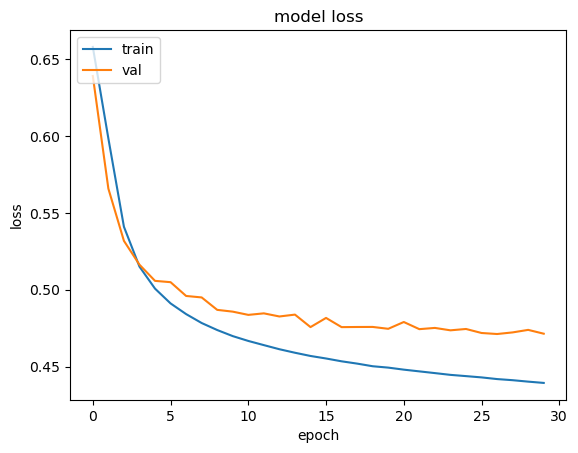

In [66]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

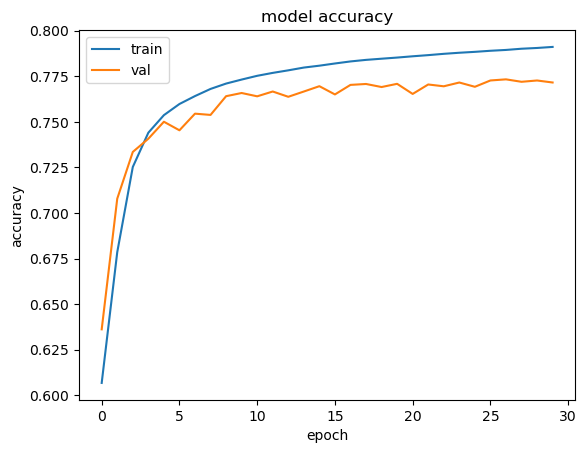

In [67]:
plt.plot(history.history['Accuracy'])
plt.plot(history.history['val_Accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

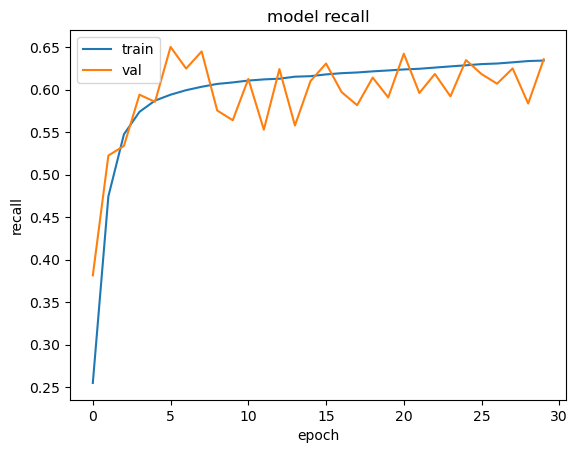

In [68]:
plt.plot(history.history['recall'])
plt.plot(history.history['val_recall'])
plt.title('model recall')
plt.ylabel('recall')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

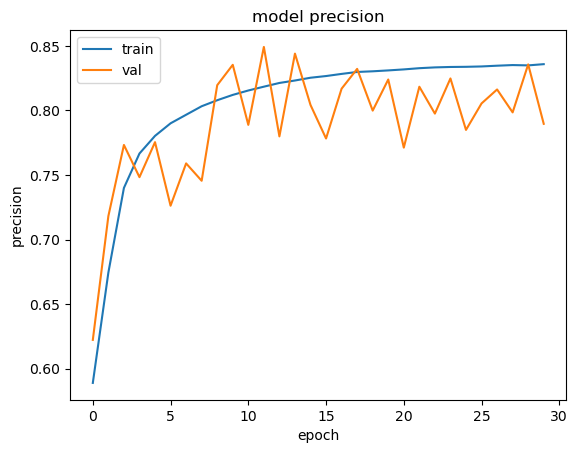

In [69]:
plt.plot(history.history['precision'])
plt.plot(history.history['val_precision'])
plt.title('model precision')
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [71]:
score_ann = model.evaluate(np.load("./dataset/test.npy")[:,1:], np.load("./dataset/test.npy")[:,0]) 

print('Test loss:', score_ann[0]) 
print('Test accuracy:', score_ann[1])
print('Test recall:', score_ann[2])
print('Test precision:', score_ann[3])

4830/4830 [==============================] - 11s 2ms/step - loss: 0.4700 - Accuracy: 0.7715 - recall: 0.6350 - precision: 0.7889
Test loss: 0.4699893593788147
Test accuracy: 0.771496057510376
Test recall: 0.6350252032279968
Test precision: 0.7889240384101868


In [72]:
predicted = model.predict(np.load("./dataset/test.npy")[:,1:]) 

4830/4830 [==============================] - 5s 950us/step


In [73]:
(predicted < 0.5).sum()/predicted.shape[0]*100

65.61278633363531

In [74]:
(predicted >= 0.5).sum()/predicted.shape[0]*100

34.387213666364694

In [75]:
model.save("./models/model.keras")

In [2]:
loaded_model = tf.keras.models.load_model("./models/model.keras")

now we remove departure delay

In [2]:
df = pd.read_csv("./dataset/flights_processed.csv", index_col = 0)

In [3]:
df

,is_delayed,DepDelay,origin_ABE,origin_ABI,origin_ABQ,origin_ACT,origin_ACY,origin_ADQ,origin_AKN,origin_ALB,...,month_sin,month_cos,monthDay_sin,monthDay_cos,weekDay_sin,weekDay_cos,CRSDepTime_hour_sin,CRSDepTime_hour_cos,CRSDArrTime_hour_sin,CRSDArrTime_hour_cos
0,0,0.105485,0,0,0,0,0,0,0,0,...,5.000000e-01,0.866025,-0.299363,-0.954139,4.338837e-01,-0.900969,-1.000000,-1.836970e-16,-0.965926,0.258819
1,1,0.104958,0,0,0,0,0,0,0,0,...,5.000000e-01,0.866025,-0.485302,-0.874347,-4.338837e-01,-0.900969,-1.000000,-1.836970e-16,-0.965926,0.258819
2,1,0.113397,0,0,0,0,0,0,0,0,...,5.000000e-01,0.866025,-0.651372,-0.758758,-9.749279e-01,-0.222521,-1.000000,-1.836970e-16,-0.965926,0.258819
3,1,0.106013,0,0,0,0,0,0,0,0,...,5.000000e-01,0.866025,-0.790776,-0.612106,-7.818315e-01,0.623490,-1.000000,-1.836970e-16,-0.965926,0.258819
4,1,0.107595,0,0,0,0,0,0,0,0,...,5.000000e-01,0.866025,-0.897805,-0.440394,-2.449294e-16,1.000000,-1.000000,-1.836970e-16,-0.965926,0.258819
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5723668,1,0.109705,0,0,0,0,0,0,0,0,...,-2.449294e-16,1.000000,0.299363,-0.954139,-9.749279e-01,-0.222521,0.965926,-2.588190e-01,0.258819,-0.965926
5723669,1,0.111814,0,0,0,0,0,0,0,0,...,-2.449294e-16,1.000000,0.101168,-0.994869,-7.818315e-01,0.623490,0.965926,-2.588190e-01,0.258819,-0.965926
5723670,0,0.105485,0,0,0,0,0,0,0,0,...,-2.449294e-16,1.000000,-0.101168,-0.994869,-2.449294e-16,1.000000,0.965926,-2.588190e-01,0.258819,-0.965926
5723671,0,0.105485,0,0,0,0,0,0,0,0,...,-2.449294e-16,1.000000,-0.299363,-0.954139,7.818315e-01,0.623490,0.965926,-2.588190e-01,0.258819,-0.965926


In [4]:
df.drop(["DepDelay"], axis = 1, inplace = True)

In [5]:
df = df.sample(frac=0.30, random_state = 42).reset_index(drop=True)

In [6]:
train, validation_test = train_test_split(df, test_size=0.3)

In [7]:
train.shape

(1201971, 484)

In [8]:
validation, test = train_test_split(validation_test, test_size=0.30)

In [9]:
test.shape

(154540, 484)

In [10]:
validation.shape

(360591, 484)

In [11]:
train.to_csv("./dataset/train.csv")
validation.to_csv("./dataset/validation.csv")
test.to_csv("./dataset/test.csv")

In [12]:
train = pd.read_csv("./dataset/train.csv", index_col = 0)
train

,is_delayed,origin_ABE,origin_ABI,origin_ABQ,origin_ACT,origin_ACY,origin_ADQ,origin_AKN,origin_ALB,origin_AMA,...,month_sin,month_cos,monthDay_sin,monthDay_cos,weekDay_sin,weekDay_cos,CRSDepTime_hour_sin,CRSDepTime_hour_cos,CRSDArrTime_hour_sin,CRSDArrTime_hour_cos
1674361,1,0,0,0,0,0,0,0,0,0,...,-8.660254e-01,-0.500000,-0.968077,-0.250653,4.338837e-01,-0.900969,0.707107,-7.071068e-01,0.258819,-9.659258e-01
676797,1,0,0,0,0,0,0,0,0,0,...,-8.660254e-01,-0.500000,0.848644,0.528964,-2.449294e-16,1.000000,-0.500000,-8.660254e-01,-0.866025,-5.000000e-01
918859,0,0,0,0,0,0,0,0,0,0,...,-8.660254e-01,0.500000,0.897805,-0.440394,4.338837e-01,-0.900969,0.866025,-5.000000e-01,0.707107,-7.071068e-01
1121361,0,0,0,0,0,0,0,0,0,0,...,1.224647e-16,-1.000000,0.937752,0.347305,4.338837e-01,-0.900969,1.000000,6.123234e-17,0.965926,-2.588190e-01
975619,1,0,0,0,0,0,0,0,0,0,...,-5.000000e-01,-0.866025,0.101168,-0.994869,-2.449294e-16,1.000000,-0.866025,-5.000000e-01,-1.000000,-1.836970e-16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
403123,1,0,0,0,0,0,0,0,0,0,...,-2.449294e-16,1.000000,-0.571268,0.820763,-9.749279e-01,-0.222521,-0.258819,-9.659258e-01,-0.866025,-5.000000e-01
447347,0,0,0,0,0,0,0,0,0,0,...,8.660254e-01,-0.500000,0.201299,0.979530,-2.449294e-16,1.000000,-0.965926,2.588190e-01,-0.866025,5.000000e-01
219569,1,0,0,0,0,0,0,0,0,0,...,1.224647e-16,-1.000000,-0.299363,-0.954139,-2.449294e-16,1.000000,0.965926,-2.588190e-01,0.707107,-7.071068e-01
93602,0,0,0,0,0,0,0,0,0,0,...,-5.000000e-01,0.866025,0.101168,-0.994869,-4.338837e-01,-0.900969,-0.866025,5.000000e-01,-0.258819,9.659258e-01


In [13]:
train = train.to_numpy(dtype="float32")
train.shape

(1201971, 484)

In [14]:
np.save('./dataset/train.npy', train) 

In [15]:
validation = pd.read_csv("./dataset/validation.csv", index_col = 0)
validation = validation.to_numpy(dtype="float32")
validation.shape
np.save('./dataset/validation.npy', validation) 

In [16]:
test = pd.read_csv("./dataset/test.csv", index_col = 0)
test = test.to_numpy(dtype="float32")
test.shape
np.save('./dataset/test.npy', test) 

In [17]:
test = ""
train = ""
validation = ""

In [18]:
trainMatrix = np.load('./dataset/train.npy')

In [19]:
batch_size = 512

In [20]:
trainMatrix.shape[0]/batch_size

2347.599609375

In [21]:
contBatches = 0
for i in range(0, trainMatrix.shape[0], batch_size):
    batch = trainMatrix[i:i+batch_size, 0:]
    np.save('./dataset/train_batches/X_'+str(contBatches)+ '.npy', batch[:,1:])
    np.save('./dataset/train_batches/y_'+str(contBatches)+ '.npy', batch[:,0])
    contBatches+=1
contBatches

2348

In [22]:
trainMatrix = ""

In [23]:
contBatches = 0
validationMatrix = np.load('./dataset/validation.npy')
for i in range(0, validationMatrix.shape[0], batch_size):
    batch = validationMatrix[i:i+batch_size, 0:]
    np.save('./dataset/validation_batches/X_'+str(contBatches)+ '.npy', batch[:,1:])
    np.save('./dataset/validation_batches/y_'+str(contBatches)+ '.npy', batch[:,0])
    contBatches+=1
validationMatrix = ""
contBatches

705

In [24]:
testMatrix = np.load('./dataset/test.npy')
contBatches = 0
for i in range(0, testMatrix.shape[0], batch_size):
    batch = testMatrix[i:i+batch_size, 0:]
    np.save('./dataset/test_batches/X_'+str(contBatches)+ '.npy', batch[:,1:])
    np.save('./dataset/test_batches/y_'+str(contBatches)+ '.npy', batch[:,0])
    contBatches+=1
testMatrix = ""
contBatches

302

In [25]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self, list_IDs, mode):
        'Initialization'
        self.list_IDs = list_IDs
        self.on_epoch_end()
        self.mode = mode
        self.shuffle = True

    def __len__(self):
        return int(len(self.list_IDs))

    def __getitem__(self, index):
        'Generate one batch of data'
        X, y = self.__data_generation(index)
        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = self.list_IDs
        np.random.shuffle(self.indexes)

    def load_file(self, id_file, location):
        x_file_path = os.path.join(location, "X_"+str(id_file)+ ".npy")
        y_file_path = os.path.join(location, "y_"+str(id_file)+ ".npy")
        # Store sample
        X = np.load(x_file_path)
        # Store class
        y = np.load(y_file_path).astype(int)
        return X, y       

    def __data_generation(self, id_file):
        """Generates data containing batch_size samples"""
        if self.mode == "train":
            data_loc = "./dataset/train_batches/"
            # Generate data
            X, y = self.load_file(id_file, data_loc)
            return X, y
        elif self.mode == "val":
            data_loc = "./dataset/validation_batches/"
            X, y = self.load_file(id_file, data_loc)
            return X, y
        
training_generator = DataGenerator(np.arange(0, 2348, 1, dtype=int), "train")
validation_generator = DataGenerator(np.arange(0, 705, 1, dtype=int), "val")

In [26]:
output_dim = 1
input_dim = 483
model = Sequential()
model.add(Input(shape=(input_dim,)))
model.add(Dense(200, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(output_dim, activation='sigmoid'))
opt = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=opt, loss=tf.keras.losses.BinaryCrossentropy(from_logits = False), 
              metrics=['Accuracy', 'Recall', 'Precision'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 200)               96800     
                                                                 
 dense_1 (Dense)             (None, 100)               20100     
                                                                 
 dense_2 (Dense)             (None, 50)                5050      
                                                                 
 dense_3 (Dense)             (None, 10)                510       
                                                                 
 dense_4 (Dense)             (None, 1)                 11        
                                                                 
Total params: 122,471
Trainable params: 122,471
Non-trainable params: 0
_________________________________________________________________


In [27]:
history = model.fit(x=training_generator,
                    validation_data=validation_generator,
                    epochs=30,
                    verbose=1)

Epoch 1/30
2348/2348 [==============================] - 13s 4ms/step - loss: 0.6621 - Accuracy: 0.6009 - recall: 0.2691 - precision: 0.5676 - val_loss: 0.6557 - val_Accuracy: 0.6102 - val_recall: 0.3800 - val_precision: 0.5657
Epoch 2/30
2348/2348 [==============================] - 11s 5ms/step - loss: 0.6504 - Accuracy: 0.6170 - recall: 0.3617 - precision: 0.5818 - val_loss: 0.6501 - val_Accuracy: 0.6176 - val_recall: 0.3254 - val_precision: 0.5967
Epoch 3/30
2348/2348 [==============================] - 11s 4ms/step - loss: 0.6445 - Accuracy: 0.6253 - recall: 0.3893 - precision: 0.5923 - val_loss: 0.6468 - val_Accuracy: 0.6223 - val_recall: 0.3438 - val_precision: 0.6020
Epoch 4/30
2348/2348 [==============================] - 10s 4ms/step - loss: 0.6399 - Accuracy: 0.6309 - recall: 0.4090 - precision: 0.5983 - val_loss: 0.6440 - val_Accuracy: 0.6269 - val_recall: 0.3671 - val_precision: 0.6049
Epoch 5/30
2348/2348 [==============================] - 10s 4ms/step - loss: 0.6358 - Accura

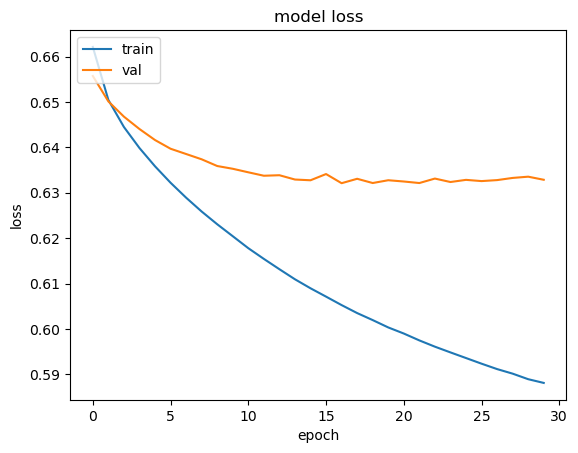

In [28]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

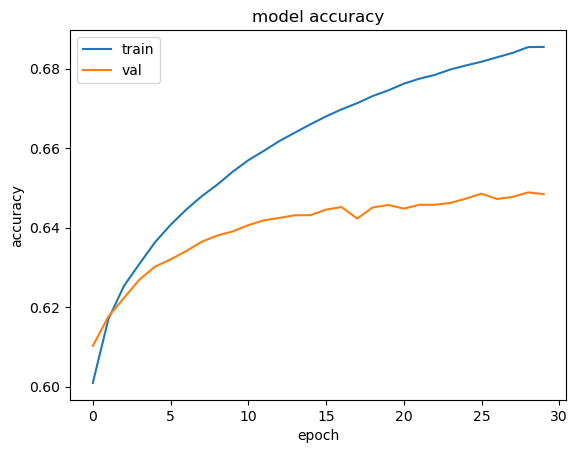

In [29]:
plt.plot(history.history['Accuracy'])
plt.plot(history.history['val_Accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

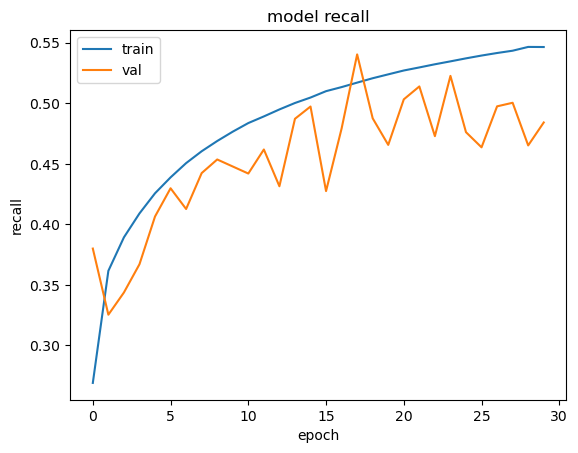

In [30]:
plt.plot(history.history['recall'])
plt.plot(history.history['val_recall'])
plt.title('model recall')
plt.ylabel('recall')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

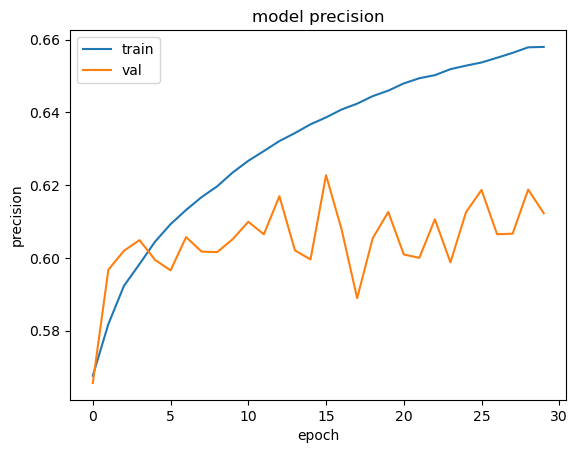

In [31]:
plt.plot(history.history['precision'])
plt.plot(history.history['val_precision'])
plt.title('model precision')
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [32]:
score_ann = model.evaluate(np.load("./dataset/test.npy")[:,1:], np.load("./dataset/test.npy")[:,0]) 

print('Test loss:', score_ann[0]) 
print('Test accuracy:', score_ann[1])
print('Test recall:', score_ann[2])
print('Test precision:', score_ann[3])

4830/4830 [==============================] - 11s 2ms/step - loss: 0.6302 - Accuracy: 0.6495 - recall: 0.4841 - precision: 0.6117
Test loss: 0.6301695108413696
Test accuracy: 0.6494758725166321
Test recall: 0.4841121435165405
Test precision: 0.6117053031921387


In [33]:
predicted = model.predict(np.load("./dataset/test.npy")[:,1:]) 

4830/4830 [==============================] - 5s 984us/step


In [34]:
(predicted < 0.5).sum()/predicted.shape[0]*100

66.30063414002846

In [35]:
(predicted >= 0.5).sum()/predicted.shape[0]*100

33.69936585997153

In [36]:
model.save("./models/model2.keras")

In [2]:
loaded_model2 = tf.keras.models.load_model("./models/model2.keras")

# KNN

In [37]:
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns
from sklearn.model_selection import cross_val_score

In [ ]:
k_values = [i for i in range (20,100, 20)]
scores = []
X = np.load("./dataset/train.npy")[:,1:]
y = np.load("./dataset/train.npy")[:,0]
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    score = cross_val_score(knn, X, y, cv=5)
    scores.append(np.mean(score))

In [ ]:
sns.lineplot(x = k_values, y = scores, marker = 'o')
plt.xlabel("K Values")
plt.ylabel("Accuracy Score")

In [308]:
knn = KNeighborsClassifier(n_neighbors=150)
knn.fit(X, y)
y_pred = knn.predict(np.load("./dataset/test.npy")[:,1:])

In [309]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
accuracy = accuracy_score(np.load("./dataset/test.npy")[:,0], y_pred)
print("Accuracy:", accuracy)
accuracy = precision_score(np.load("./dataset/test.npy")[:,0], y_pred)
print("Precision:", accuracy)
accuracy = recall_score(np.load("./dataset/test.npy")[:,0], y_pred)
print("Recall:", accuracy)

Accuracy: 0.5823643410852714
Precision: 0.5727081138040042
Recall: 0.5435


# Decision Tree

In [310]:
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation

In [315]:
# Create Decision Tree classifer object
clf = DecisionTreeClassifier(criterion="entropy")

# Train Decision Tree Classifer
clf = clf.fit(X,y)

#Predict the response for test dataset
y_pred = clf.predict(np.load("./dataset/test.npy")[:,1:])

In [316]:
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(np.load("./dataset/test.npy")[:,0], y_pred))
print("Precision:",metrics.precision_score(np.load("./dataset/test.npy")[:,0], y_pred))
print("Recall:",metrics.recall_score(np.load("./dataset/test.npy")[:,0], y_pred))

Accuracy: 0.6339631782945736
Precision: 0.6212196331184928
Recall: 0.6265


In [326]:
train = pd.read_csv("./dataset/train.csv", index_col = 0)
train = train[train.columns.drop(list(train.filter(regex='origin')))]
train = train[train.columns.drop(list(train.filter(regex='dest')))]
train

,is_delayed,DepDelay,carrier_AA,carrier_AQ,carrier_AS,carrier_CO,carrier_DL,carrier_HP,carrier_ML (1),carrier_MQ,...,month_sin,month_cos,monthDay_sin,monthDay_cos,weekDay_sin,weekDay_cos,CRSDepTime_hour_sin,CRSDepTime_hour_cos,CRSDArrTime_hour_sin,CRSDArrTime_hour_cos
33366,1,0.393012,0,0,0,1,0,0,0,0,...,5.000000e-01,8.660254e-01,0.101168,-0.994869,9.749279e-01,-0.222521,-0.965926,2.588190e-01,-0.707107,7.071068e-01
74080,1,0.390490,0,0,0,0,1,0,0,0,...,-5.000000e-01,-8.660254e-01,0.998717,-0.050649,7.818315e-01,0.623490,0.965926,-2.588190e-01,0.866025,-5.000000e-01
22560,0,0.389409,0,0,0,0,0,0,0,0,...,1.224647e-16,-1.000000e+00,0.790776,-0.612106,9.749279e-01,-0.222521,-0.866025,5.000000e-01,-0.500000,8.660254e-01
65528,1,0.390850,1,0,0,0,0,0,0,0,...,-2.449294e-16,1.000000e+00,0.897805,-0.440394,9.749279e-01,-0.222521,1.000000,6.123234e-17,0.866025,-5.000000e-01
82998,0,0.390490,1,0,0,0,0,0,0,0,...,1.000000e+00,6.123234e-17,-0.988468,0.151428,-2.449294e-16,1.000000,-0.866025,-5.000000e-01,-1.000000,-1.836970e-16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30156,0,0.391210,0,0,0,0,1,0,0,0,...,-5.000000e-01,8.660254e-01,0.651372,-0.758758,9.749279e-01,-0.222521,-1.000000,-1.836970e-16,-0.965926,2.588190e-01
35891,0,0.390130,0,0,0,1,0,0,0,0,...,5.000000e-01,8.660254e-01,-0.988468,0.151428,-4.338837e-01,-0.900969,0.500000,-8.660254e-01,-0.866025,-5.000000e-01
6385,1,0.392291,0,0,0,0,1,0,0,0,...,8.660254e-01,-5.000000e-01,0.571268,0.820763,4.338837e-01,-0.900969,-0.707107,-7.071068e-01,-0.965926,-2.588190e-01
13144,1,0.390490,0,0,1,0,0,0,0,0,...,-1.000000e+00,-1.836970e-16,0.897805,-0.440394,9.749279e-01,-0.222521,0.500000,-8.660254e-01,0.258819,-9.659258e-01


In [327]:
# Create Decision Tree classifer object
clf = DecisionTreeClassifier(criterion="entropy")

# Train Decision Tree Classifer
clf = clf.fit(train.iloc[:, 1:],train.iloc[:, 0])

#Predict the response for test dataset
test = pd.read_csv("./dataset/test.csv", index_col = 0)
test = test[test.columns.drop(list(test.filter(regex='origin')))]
test = test[test.columns.drop(list(test.filter(regex='dest')))]

y_pred = clf.predict(test.iloc[:, 1:])

In [329]:
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(test.iloc[:, 0], y_pred))
print("Precision:",metrics.precision_score(test.iloc[:, 0], y_pred))
print("Recall:",metrics.recall_score(test.iloc[:, 0], y_pred))

Accuracy: 0.6170058139534884
Precision: 0.605648008068583
Recall: 0.6005


In [330]:
train = pd.read_csv("./dataset/train.csv", index_col = 0)
train = train[train.columns.drop(list(train.filter(regex='origin')))]
train = train[train.columns.drop(list(train.filter(regex='dest')))]
train = train[train.columns.drop(list(train.filter(regex='carrier')))]
train

,is_delayed,DepDelay,month_sin,month_cos,monthDay_sin,monthDay_cos,weekDay_sin,weekDay_cos,CRSDepTime_hour_sin,CRSDepTime_hour_cos,CRSDArrTime_hour_sin,CRSDArrTime_hour_cos
33366,1,0.393012,5.000000e-01,8.660254e-01,0.101168,-0.994869,9.749279e-01,-0.222521,-0.965926,2.588190e-01,-0.707107,7.071068e-01
74080,1,0.390490,-5.000000e-01,-8.660254e-01,0.998717,-0.050649,7.818315e-01,0.623490,0.965926,-2.588190e-01,0.866025,-5.000000e-01
22560,0,0.389409,1.224647e-16,-1.000000e+00,0.790776,-0.612106,9.749279e-01,-0.222521,-0.866025,5.000000e-01,-0.500000,8.660254e-01
65528,1,0.390850,-2.449294e-16,1.000000e+00,0.897805,-0.440394,9.749279e-01,-0.222521,1.000000,6.123234e-17,0.866025,-5.000000e-01
82998,0,0.390490,1.000000e+00,6.123234e-17,-0.988468,0.151428,-2.449294e-16,1.000000,-0.866025,-5.000000e-01,-1.000000,-1.836970e-16
...,...,...,...,...,...,...,...,...,...,...,...,...
30156,0,0.391210,-5.000000e-01,8.660254e-01,0.651372,-0.758758,9.749279e-01,-0.222521,-1.000000,-1.836970e-16,-0.965926,2.588190e-01
35891,0,0.390130,5.000000e-01,8.660254e-01,-0.988468,0.151428,-4.338837e-01,-0.900969,0.500000,-8.660254e-01,-0.866025,-5.000000e-01
6385,1,0.392291,8.660254e-01,-5.000000e-01,0.571268,0.820763,4.338837e-01,-0.900969,-0.707107,-7.071068e-01,-0.965926,-2.588190e-01
13144,1,0.390490,-1.000000e+00,-1.836970e-16,0.897805,-0.440394,9.749279e-01,-0.222521,0.500000,-8.660254e-01,0.258819,-9.659258e-01


In [331]:
# Create Decision Tree classifer object
clf = DecisionTreeClassifier(criterion="entropy")

# Train Decision Tree Classifer
clf = clf.fit(train.iloc[:, 1:],train.iloc[:, 0])

#Predict the response for test dataset
test = pd.read_csv("./dataset/test.csv", index_col = 0)
test = test[test.columns.drop(list(test.filter(regex='origin')))]
test = test[test.columns.drop(list(test.filter(regex='dest')))]
test = test[test.columns.drop(list(test.filter(regex='carrier')))]

y_pred = clf.predict(test.iloc[:, 1:])

In [332]:
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(test.iloc[:, 0], y_pred))
print("Precision:",metrics.precision_score(test.iloc[:, 0], y_pred))
print("Recall:",metrics.recall_score(test.iloc[:, 0], y_pred))

Accuracy: 0.6153100775193798
Precision: 0.6037260825780463
Recall: 0.5995


[Text(0.7460558255961167, 0.9861111111111112, 'x[0] <= 0.392\nentropy = 1.0\nsamples = 32099\nvalue = [16386, 15713]'),
 Text(0.5168929129521501, 0.9583333333333334, 'x[0] <= 0.391\nentropy = 0.954\nsamples = 24889\nvalue = [15571, 9318]'),
 Text(0.2179192911449423, 0.9305555555555556, 'x[0] <= 0.39\nentropy = 0.908\nsamples = 18130\nvalue = [12262, 5868]'),
 Text(0.03300099195516927, 0.9027777777777778, 'x[0] <= 0.387\nentropy = 0.79\nsamples = 2431\nvalue = [1855, 576]'),
 Text(0.032888052638875655, 0.875, 'entropy = 0.0\nsamples = 35\nvalue = [35, 0]'),
 Text(0.03311393127146288, 0.875, 'x[5] <= 0.217\nentropy = 0.796\nsamples = 2396\nvalue = [1820, 576]'),
 Text(0.013032689755698141, 0.8472222222222222, 'x[3] <= -0.688\nentropy = 0.747\nsamples = 1319\nvalue = [1038, 281]'),
 Text(0.0034508255158150337, 0.8194444444444444, 'x[8] <= 0.916\nentropy = 0.863\nsamples = 319\nvalue = [228, 91]'),
 Text(0.0033378861995214198, 0.7916666666666666, 'x[2] <= -0.683\nentropy = 0.872\nsamples =

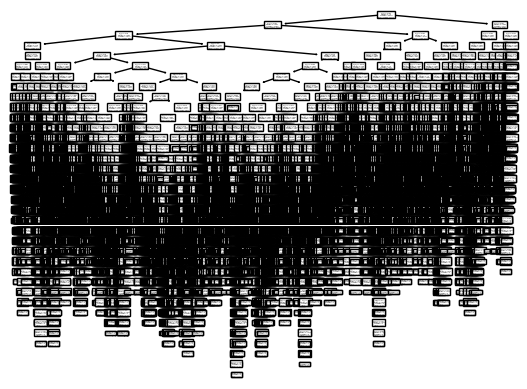

In [334]:
from sklearn import tree
tree.plot_tree(clf)

# Models comparison

Charts of the three metrics